This is the initial exploration of data for the proposed project to explore the hypothesis that
the valence of affect or arousal impacts the variance of diversity in colexification of words.

The null hypothesis is that there will be no difference in the diversity of words between (A)high and low arousal measures and (B) positive and negative valence measures when data is compared using an established library for these measures. 

Method: Using CLICS data set, and data from The NRC Valence, Arousal, and Dominance (NRC-VAD) Lexicon


From the the Clics Data I will find the 25 most diverse terms in colexification and chart them using the best translation to measure their affect and arousal rating in the NRC-VAD data. 

I will also extract the top 25% highest and lowest arousal and top 25% highest positive and negative valenced words and copare the sets on a scale of diversity in the CLICS data.

I will then test the distributions, and values against the mean. Get a t-value for the group and compare it to the alpha which I will establish as .05 to measure significance. 



In [32]:
import numpy as np
import pandas as pd
# the library below is useful for estimating the progress of a for loop
# the use of tqdm will be displayed in Demo 2
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st
import math

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv(r"/Users/petejohansson/PycharmProjects/cog260project/data/Colex_Data/df_all_raw.csv")
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

/var/folders/97/z59w4cy52k5chpbqvdcvkc280000gn/T/ipykernel_62839/3887541862.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/Users/petejohansson/PycharmProjects/cog260project/data/Colex_Data/df_all_raw.csv")


In [3]:
num_languages = df['variety'].nunique()
print(f"Number of unique languages: {num_languages}")

num_languages_per_family = df.groupby("family")['variety'].count()
num_languages_per_family

sorted_data = num_languages_per_family.sort_values()
print(len(sorted_data))


Number of unique languages: 3050
201


In [4]:
#This puts all one word values into a dictionary and returns an affect measure between -1 and +1.
#I captured levels for phrases of two words (only apprx 300), in problems list which I will employ if I find a need.

valence_dict = {}
problems = []
with open('/Users/petejohansson/PycharmProjects/cog260project/data/NRC-VAD-Lexicon/Project_valence-NRC-VAD-Lexicon.txt', 'r') as txt:
    for line in txt.readlines():
        if len(line.split()) ==2:
            valence_dict[line.split()[0]]=float(line.split()[1])
        else:
            problems.append(line)
        
print(valence_dict['dread'],valence_dict['positive'] )

arousal_dict = {}
problems_arousal = []
with open('/Users/petejohansson/PycharmProjects/cog260project/data/NRC-VAD-Lexicon/Project_arousal-NRC-VAD-Lexicon.txt', 'r') as txt1:
    for line in txt1.readlines():
        if len(line.split()) ==2:
            arousal_dict[line.split()[0]]=float(line.split()[1])
        else:
            problems_arousal.append(line)
print(arousal_dict['murder'], arousal_dict['kiss'])
print(len(problems), len(problems_arousal))

-0.694 0.918
0.884 0.626
132 132


In [5]:
# in order to find the top and bottom Quartiles, I will need to intially look at unique
#conception_glosses to extract them and sort them.
conceptions = df['concepticon_gloss'].nunique()
print(f"Number of conceptions: {conceptions}")
# ordered_concepts = df.groupby(['concepticon_gloss'].nunique())

#I am employing the already written code for exploration of CLICS at the moment
                              
def per_lang_colexification(curr_df):
    """
    Calculate the colexification frequency of pairs of concepts present in the current language.
    """
    all_combos_dict = {}
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_gloss']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:
            if combo in all_combos_dict:
                all_combos_dict[combo] += 1
            else:
                all_combos_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp = pd.DataFrame.from_dict(all_combos_dict, "index").reset_index()
    per_lang = pd.DataFrame(tmp['index'].tolist(), columns=['concept_1', "concept_2"])
    per_lang['colexification_count'] = tmp[0]
    return per_lang

def main():
    all_dfs = []
    for variety in tqdm(df['variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df = per_lang_colexification(colex)
        all_dfs.append(curr_df)
    mega = pd.concat(all_dfs)
    colex_counts = mega.groupby(["concept_1", "concept_2"]).sum().reset_index()
    return colex_counts

colex_counts = main()

ordered_count =colex_counts.sort_values(by='colexification_count')
# quartiles = len(ordered_count)/4


Number of conceptions: 2919


100%|██████████| 3050/3050 [02:36<00:00, 19.50it/s]


In [23]:
ordered = np.array(ordered_count)
print(ordered.shape, ordered.size, ordered.dtype, ordered.data)

(74330, 3) 222990 object <memory at 0x1562b01e0>


In [25]:
import math

full_length = len(ordered_count)
quartile = full_length//4


print(quartile)
ordered = np.array(ordered_count)
print(ordered.shape)


def get_valence(start, stop, dictionary_type):
    """Gets all values from hard assigned array 'ordered' sorted to 'colexification_count', and then returns
        two lists of words and values. The first list of words are those words and found values
        if and only if, both words appear in the provided value dictionary. This list has
        first value as String of concept 1, Float of its value in dictionary, String of concept 2,
        Float of its value in dictionary, and Integer of its colexification count.
        The second returned list is all the concepts where they were not both found in the
        dictionary.

        @parameters:
        (int) start which is used as a starting index value,
        (int) stop which is used as a stopping index value.
        (dict) dictionary_type is used as the dictionary to search values in

        @return: list[[String, Float, String, Float, int],[String, String, int]]
"""
    test_value = []
    unavailable =[]
    for index in range(start, stop, 1):
        key_a, key_b, count_num = ordered[index][0].lower(), ordered[index][1].lower(), ordered[index][2]
        if key_a in dictionary_type.keys() and key_b in dictionary_type.keys():
            test_value.append([key_a, dictionary_type[key_a], key_b, dictionary_type[key_b], count_num])
        else:
            unavailable.append([key_a, key_b, count_num])
    return [test_value, unavailable]

def partial_array(start, stop, input_list):
    """ This function returns the specific portion of a list
        using the parameters as index points, and the list.
        Pre-conditions: start parameter and stop parameter must be valid as in 0 or greater, and
        less than length of list -1
        @Parameters:
        (int) start
        (int) stop
        (list) input_list

        @return: list[]
        """
    list_return = []
    for j in range(start, stop, 1):
        list_return.append(input_list[j])
    return list_return

def near_values(float1, float2):
    """
    This function returns an integer ranking of how close in value two compared floats are.
    (1 being the closest, 10 being the least close or greater than .5 tolerance)
    :param float1: float value of first comparison
    :param float2: float value of second comparison
    :return: int value for rank
    """
    tolerance_list = [[0.5, 9], [0.3, 8], [0.2, 7], [0.1, 6], [0.05, 5], [0.01, 4], [0.005, 3], [0.001, 2], [0.0001, 1]]
    tolerance_value = True
    result = 10

    for toler in tolerance_list:
        tolerance_value = math.isclose(float1,float2, abs_tol = toler[0])
        if tolerance_value:
            result = toler[1]
        else:
            return result
    return result


def concept_values(results):
    """
    This function returns two versions of data for use in both graphs, and more dataframe exploration.
    It takes in the first list created by get_valence and creates a new dataframe, and a new list of arrays and returns them.
    The list of data arrays is just values which represent float value of concept 1 rating, float value of concept 2 rating, integer value
    of colxifiaction number, and float value of the average of the concept 1 and concept 2 value.
    the dataframe is the column values of 'Concept1', 'Concept1Value', 'Concept2', 'Concept2Value', 'ColexValue', 'CombinedAverage', 'NearRating'.
    :param results: ist[[String, Float, String, Float, int]
    :return: list[array, array, array, array], dataframe['Concept1', 'Concept1Value', 'Concept2', 'Concept2Value', 'ColexValue', 'CombinedAverage', 'NearRating']
    """
    concept_a, concept_b, label_num, mean_of_both= [], [], [], []
    my_list = []
    for xx in range(0, len(results)):
        concept_a.append(results[xx][1]), concept_b.append(results[xx][3]), label_num.append(results[xx][4]), mean_of_both.append((results[xx][1] +results[xx][3]) / 2)
        my_list.append([results[xx][0],results[xx][1],results[xx][2], results[xx][3], results[xx][4], (results[xx][1] +results[xx][3]) / 2, near_values(results[xx][1],results[xx][3])])
    my_array = np.array(my_list)
    datfram = pd.DataFrame(my_array, columns= ['Concept1', 'Concept1Value', 'Concept2', 'Concept2Value', 'ColexValue', 'CombinedAverage', 'NearRating'])
    listofdata =[np.array(concept_a, dtype=float), np.array(concept_b, dtype=float), np.array(label_num, dtype=int), np.array(mean_of_both, dtype=float)]
    return  listofdata, datfram

from_high = full_length-quartile


#### Data for analysis ####

## Lowest quartile values ##
# low_values_and_missing = get_valence(1, quartile, valence_dict)
# low_results = low_values_and_missing[0]
# low_graph = concept_values(low_results)
#
# low_values_and_missing_arousal = get_valence(1, quartile, arousal_dict)
# low_results_arousal = low_values_and_missing_arousal[0]
# low_graph_arousal = concept_values(low_results_arousal)

## Highest quartile ##
high_value_and_missing = get_valence(from_high, full_length, valence_dict)
high_results = high_value_and_missing[0]
high_graph, high_affect_dataframe = concept_values(high_results)


high_value_and_missing_arousal = get_valence(from_high, full_length, arousal_dict)
high_results_arousal = high_value_and_missing_arousal[0]
high_graph_arousal, high_arousal_dataframe = concept_values(high_results_arousal)

## Full data ##
full_array_and_missing = get_valence(0,full_length, valence_dict)
full_results = full_array_and_missing[0]
full_graph, full_affect_dataframe  = concept_values(full_results)

full_array_and_missing_arousal = get_valence(0,full_length, arousal_dict)
full_results_arousal  = full_array_and_missing_arousal[0]
full_graph_arousal, full_arousal_dataframe = concept_values(full_results_arousal)



# for i in range(55748, 74330, 1):
#     key1, key2, count = ordered[i][0].lower(), ordered[i][1].lower(), ordered[i][2]
#     #print(key1, key2, count)
#     if key1 in valence_dict.keys() and key2 in valence_dict.keys():
#         high_value_test.append([key1,valence_dict[key1], key2, valence_dict[key2], count])
#     else:
#         not_found.append([key1, key2, count])
#
# for i in range(55748, 74330, 1):
#     key1, key2, count = ordered[i][0].lower(), ordered[i][1].lower(), ordered[i][2]
#     #print(key1, key2, count)
#     if key1 in valence_dict.keys() and key2 in valence_dict.keys():
#         low_value_test.append([key1,valence_dict[key1], key2, valence_dict[key2], count])
#     else:
#         not_found.append([key1, key2, count])

# print (len(low_results), len(low_values_and_missing[1]))
print (len(high_results), len(high_value_and_missing[1]))
# print(high_value_test)
# concept1, concept2, label = [], [], []
# for x in range(0,len(high_value_test)):
#     concept1.append(high_value_test[x][1]), concept2.append(high_value_test[x][3]), label.append(high_value_test[x][4])
#
    


18582
(74330, 3)
9883 8699


In [30]:

full_affect_dataframe.sort_values(by=['CombinedAverage'], inplace=True)
print(full_affect_dataframe, full_arousal_dataframe)
full_arousal_dataframe.sort_values(by=['NearRating'], inplace=True)
print(full_affect_dataframe, full_arousal_dataframe)
full_arousal_dataframe.sort_values(by=['ColexValue'], inplace=True, ascending=False)
print(full_affect_dataframe, full_arousal_dataframe)

      Concept1 Concept1Value  Concept2 Concept2Value ColexValue  \
10211     port           0.1     thing        -0.102          1   
27654     come         0.058  forehead         -0.06          1   
15295   paddle         0.122   undress        -0.124          1   
5324       ear        -0.062      head          0.06          1   
36528   basket        -0.084   beehive         0.082          4   
...        ...           ...       ...           ...        ...   
37075    happy           1.0     merry         0.958          5   
1033     happy           1.0       joy          0.96          1   
14632    laugh          0.96      love           1.0          1   
1037     happy           1.0     laugh          0.96          1   
37082    happy           1.0      love           1.0          5   

              CombinedAverage NearRating  
10211   -0.000999999999999994          8  
27654  -0.0009999999999999974          7  
15295  -0.0010000000000000009          8  
5324   -0.0010000000000

In [ ]:
### extract high ratings ####


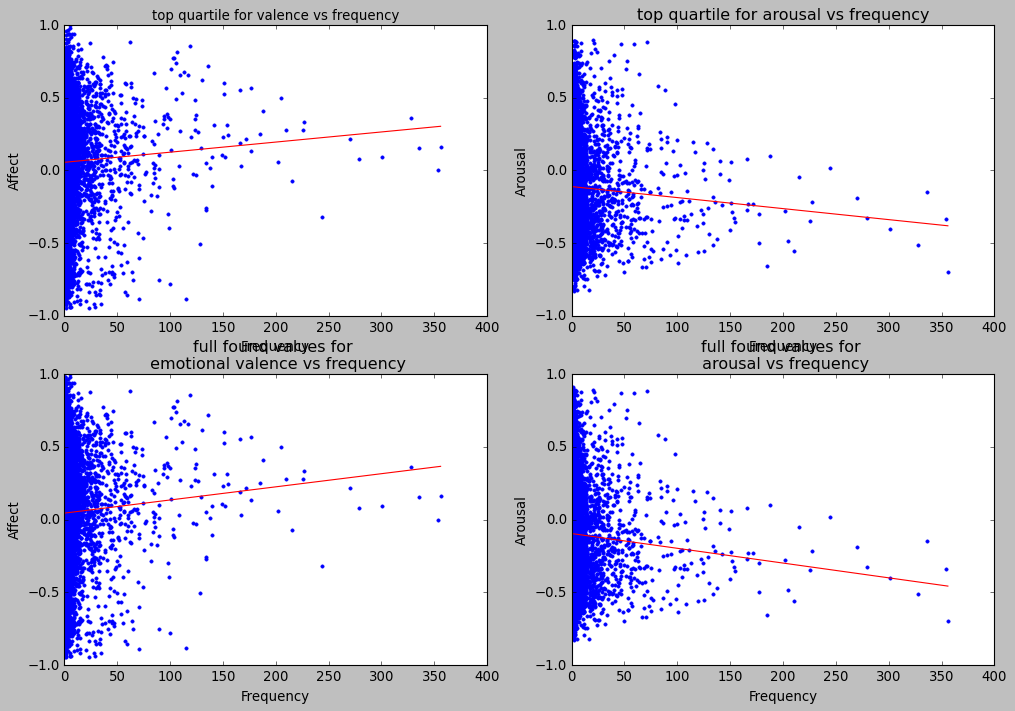

The Pearson correlation between top quartile affect  and frequency of colexification is :0.035673531482463695
The Pearson correlation between top quartile arousal and frequency of colexification is :-0.04265898202875328
The Pearson correlation between full list affect and frequency of colexification is :0.025122512201826906
The Pearson correlation between full list arousal and frequency of colexification is :-0.031001360496900346


In [33]:
#import sys
import scipy as sc
from scipy import stats as st
from scipy.stats import pearsonr
#### Linear regression Analysis ###

#deg = int(sys.argv[0])
plt.style.use('classic')
fig = plt.figure(figsize=(15,10) )
plt.subplot(2,2,1)

x1, y1 = high_graph[2], high_graph[3]
slope, intercept = np.polyfit(x1.flatten(), y1.flatten(), deg=1)
plt.plot(x1 , y1, '.')
plt.plot(x1, intercept + slope*x1, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Affect')
plt.title("top quartile for valence vs frequency", fontsize=12)

plt.subplot(2,2,2)
x2, y2 = high_graph_arousal[2], high_graph_arousal[3]
slope, intercept = np.polyfit(x2.flatten(), y2.flatten(), deg=1)
plt.plot(x2 , y2, '.')
plt.plot(x2, intercept + slope*x2, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Arousal')
plt.title("top quartile for arousal vs frequency")
# plt.subplot(3,2,3)
#
# x1, y1 = low_graph[2], low_graph[3]
# slope, intercept = np.polyfit(x1.flatten(), y1.flatten(), deg=1)
# plt.plot(x1 , y1, '.')
# plt.plot(x1, intercept + slope*x1, 'r', label='fitted line')
#
# plt.subplot(3,2,4)
# x1, y1 = low_graph_arousal[2], low_graph_arousal[3]
# slope, intercept = np.polyfit(x1.flatten(), y1.flatten(), deg=1)
# plt.plot(x1 , y1, '.')
# plt.plot(x1, intercept + slope*x1, 'r', label='fitted line')

plt.subplot(2,2,3)

x3, y3 = full_graph[2], full_graph[3]
slope, intercept = np.polyfit(x3.flatten(), y3.flatten(), deg=1)
plt.plot(x3 , y3, '.')
plt.plot(x3, intercept + slope*x3, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Affect')
plt.title("full found values for \n emotional valence vs frequency")
plt.subplot(2,2,4)
x4, y4 = full_graph_arousal[2], full_graph_arousal[3]
slope, intercept = np.polyfit(x4.flatten(), y4.flatten(), deg=1)
plt.plot(x4 , y4, '.')
plt.plot(x4, intercept + slope*x4, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Arousal')
plt.title("full found values for \n arousal vs frequency")

plt.show()

r1, p1 = st.pearsonr(x1, y1)
r2, p2 = st.pearsonr(x2, y2)
r3, p3 = st.pearsonr(x3, y3)
r4, p4 = st.pearsonr(x4, y4)
pearson_list = [(r1, p1, 'top quartile affect '), (r2, p2, 'top quartile arousal'),(r3, p3, 'full list affect'),(r4, p4, 'full list arousal')]

for x in pearson_list:
    print(f"The Pearson correlation between {x[2]} and frequency of colexification is :{x[0]}" )



In [34]:
###t-tests###

# Do a one sample t-test on the high affect valence,and one on the high arousal

mean_high_affect = np.mean(y1)
mean_high_arousal = np.mean(y2)
mean_full_affect = np.mean(y3)
mean_full_arousal= np.mean(y4)

means_list = [('mean_high_affect',y1, mean_high_affect,mean_full_affect), ('mean_high_arousal',y2, mean_high_arousal,mean_full_arousal), ('mean_full_affect', y3,mean_full_affect,mean_full_affect),('mean_full_arousal',y4,mean_full_arousal,mean_full_arousal)]

for x in means_list:
    t_stat, p_val = st.ttest_1samp(x[1], popmean=x[3])
    std_error = np.std(x[1])/np.sqrt(len(x[1]))
    print(f"The {x[0]} mean is {x[2]}test statistic is:{t_stat} and its p-value is:{p_val} ")






The mean_high_affect mean is 0.06052453708388141test statistic is:4.313923418967097 and its p-value is:1.6194156311318104e-05 
The mean_high_arousal mean is -0.11582120813518162test statistic is:-5.7299261043485465 and its p-value is:1.0341512163595048e-08 
The mean_full_affect mean is 0.046314330837026844test statistic is:0.0 and its p-value is:1.0 
The mean_full_arousal mean is -0.09864465841357174test statistic is:0.0 and its p-value is:1.0 


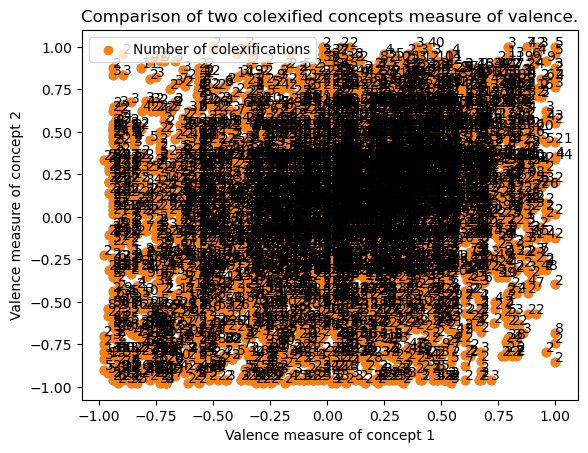

In [25]:
#this scatter plot is just proof of concept that i can extract and 
#put together some pertinent values in the data. It is not an
#example of any mathematical manipulation. 
fig, ax = plt.subplots()
# x, y, labelval = np.array(concept1), np.array(concept2), np.array(label)
# ax.scatter(x, y)
# plt.scatter(x, y, label="Number of colexifications")
#
# for i, txt in enumerate(labelval):
#     ax.annotate(txt, (x[i], y[i]))
# plt.legend(loc="upper left")
# plt.title("Comparison of two colexified concepts measure of valence.")
# plt.xlabel("Valence measure of concept 1")
# plt.ylabel("Valence measure of concept 2")


l_x, l_y, label_l = np.array(high_graph[0]), np.array(high_graph[1]), np.array(high_graph[2])
ax.scatter(l_x, l_y)
plt.scatter(l_x, l_y, label="Number of colexifications")

for i, txt in enumerate(label_l):
    ax.annotate(txt, (l_x[i], l_y[i]))
plt.legend(loc="upper left")
plt.title("Comparison of two colexified concepts measure of valence.")
plt.xlabel("Valence measure of concept 1")
plt.ylabel("Valence measure of concept 2")






plt.show()